### Read data

In [1]:
# read data
import pandas as pd 
happy = pd.read_csv("../data/lyrics/happy.csv")
sad = pd.read_csv("../data/lyrics/sad.csv")
# print(happy.shape)
# print(sad.shape)
# happy.head()
# sad.head()

# combine happy data and sad data
df = happy.append(pd.DataFrame(data = sad), ignore_index=True)
df = df[['song', 'artist', 'lyrics', 'year', 'mood']] # delete the column of url
# print (df.shape)
print (df.info())
# df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2771 entries, 0 to 2770
Data columns (total 5 columns):
song      2771 non-null object
artist    2771 non-null object
lyrics    2771 non-null object
year      2692 non-null object
mood      2771 non-null object
dtypes: object(5)
memory usage: 108.3+ KB
None


### Delete non-English lyrics

In [5]:
# https://stackoverflow.com/questions/2501746/deleting-python-modules
# delete non-English lyrics
from langdetect import detect
# from textblob import TextBlob


non_english_index = []

for i in range(df.shape[0]):
    text = df.iloc[i, 2]
#     if TextBlob(text).detect_language() != 'en':
    if detect(text) != 'en':
        non_english_index.append(i)

print(len(non_english_index))
print (non_english_index)

42
[26, 72, 221, 281, 319, 350, 400, 425, 449, 517, 716, 721, 726, 730, 733, 799, 875, 960, 1027, 1084, 1093, 1109, 1131, 1259, 1344, 1405, 1597, 1603, 1627, 1631, 1634, 1869, 1892, 2216, 2260, 2339, 2428, 2433, 2541, 2637, 2741, 2769]


In [6]:
df = df.drop(non_english_index)
df = df.reset_index(drop=True)

print(df["mood"].value_counts())

sad      1400
happy    1329
Name: mood, dtype: int64


### Save the Dataframe

In [21]:
df.to_csv('../data/clean_songs.csv', index = False)

#===============================================================

### Read the Data

In [1]:
import pandas as pd 
df = pd.read_csv("../data/clean_songs.csv")
print(df["mood"].value_counts())

happy = df.loc[df['mood'] == 'happy']
sad = df.loc[df['mood'] == 'sad']

sad      1400
happy    1329
Name: mood, dtype: int64


In [2]:
df.head()

,song,artist,lyrics,year,mood
0,Yellow Submarine,The Beatles,In the town where I was born\nLived a man who ...,1966,happy
1,Dance Dance Dance,Lykke Li,having trouble telling\nhow i feel\nbut i can ...,2008,happy
2,Crazy Little Thing Called Love,Queen,This thing called love\nI just can't handle it...,1980,happy
3,Hey Man (Now You're Really Living),Eels,Do you know what it's like to fall on the floo...,2005,happy
4,Octopus's Garden,The Beatles,I'd like to be under the sea\nIn an octopus's ...,1969,happy


### Distribution of years

In [3]:
count = df.groupby(["year", "mood"]).size().reset_index(name="Time")
# print(count.head())
count = count.pivot_table("Time", "year", "mood")
count = count.fillna(0) # replace NAN to 0
count.head()

mood,happy,sad
year,,
1953,0.0,1.0
1956,0.0,1.0
1957,2.0,1.0
1958,3.0,0.0
1959,1.0,2.0


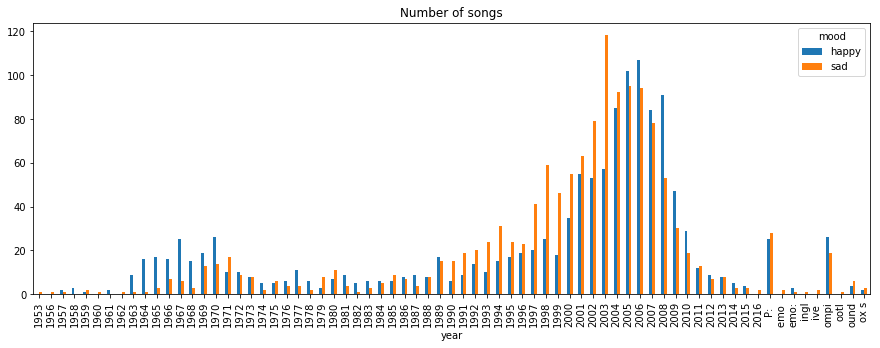

In [5]:
import matplotlib.pyplot as plt
# count.plot.bar(rot=90, figsize=(15,5), subplots=True) # 將 happy和sad分成兩張圖
# count.plot.bar(rot=90, figsize=(15,5)) # 不同畫法
count.plot(rot=90, figsize=(15,5), kind='bar')
plt.title('Number of songs')
plt.show()

### Split data

In [2]:
# split data to training and test datasets, 70/30
import numpy as np
n = len(df)
# print (n)
np.random.seed(3)
idx = np.random.choice(range(n), round(n*0.7), replace=False)
minus_idx = np.setdiff1d(range(n), idx)

train = df.iloc[idx, ]
test = df.iloc[minus_idx, ]
print (train.shape)
print (test.shape)

(1910, 5)
(819, 5)


In [3]:
# the number of moods class in train and test data
print ("Training data:")
print(train["mood"].value_counts())
print ("========================")
print ("Test data:")
print(test["mood"].value_counts())

Training data:
sad      985
happy    925
Name: mood, dtype: int64
Test data:
sad      415
happy    404
Name: mood, dtype: int64


### Use NLTK pacage

In [4]:
# preprocessing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = nltk.word_tokenize(text)
    return [lemmatizer.lemmatize(w).lower() for w in text if lemmatizer.lemmatize(w).lower() not in stop_words and w.isalpha()]

### Draw the wordcloud

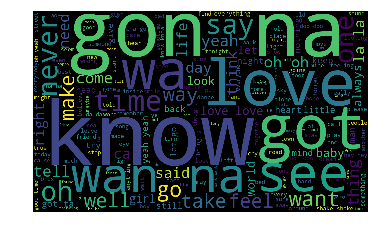

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

happy_lyrics = happy.lyrics.values
happy_text = ""
for i in happy_lyrics:
    happy_text = happy_text + " ".join(preprocess(i))

wordcloud = WordCloud(background_color="black", width=1000, height=600, margin=1).generate(happy_text) #, collocations=False
plt.imshow(wordcloud)
plt.axis("off")
# plt.show()
plt.savefig('happy.png')

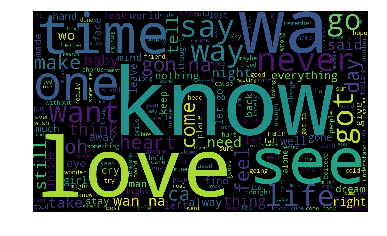

In [10]:
sad_lyrics = sad.lyrics.values
sad_text = ""
for i in sad_lyrics:
    sad_text = sad_text + " ".join(preprocess(i))

wordcloud = WordCloud(background_color="black", width=1000, height=600, margin=1).generate(sad_text)
plt.imshow(wordcloud)
plt.axis("off")
# plt.show()
plt.savefig('sad.png')

## Models

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

mood = ['happy', 'sad']

In [6]:
# transfer "happy" and "sad" to 0 and 1

y_train = []
y_test = []

# happy is 0, sad is 1
for i in train["mood"].index:
    if train["mood"][i] == "happy":
        y_train.append(0)
    else:
        y_train.append(1)


for i in test["mood"].index:
    if test["mood"][i] == "happy":
        y_test.append(0)
    else:
        y_test.append(1)

# print (y_test)

### Classifier - SVM

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', SVC(kernel= "linear", probability=True)),
])

para = {
    'vec__binary': (True, False),
    'vec__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'cls__C': (0.1, 0.5, 0.8, 1.0)
}

grid = GridSearchCV(pipeline, para, cv=5, iid=False, verbose=5, n_jobs=-1)
grid.fit(train["lyrics"], train["mood"])
print(classification_report(test["mood"], grid.predict(test["lyrics"]), mood))
print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 13.3min finished


              precision    recall  f1-score   support

       happy       0.67      0.63      0.65       404
         sad       0.66      0.70      0.68       415

    accuracy                           0.67       819
   macro avg       0.67      0.66      0.66       819
weighted avg       0.67      0.67      0.66       819

best parameters: {'cls__C': 0.5, 'vec__binary': False, 'vec__ngram_range': (1, 1)}


In [8]:
decision_scores = grid.decision_function(test["lyrics"])
svm_fpr, svm_tpr, thres = roc_curve(y_test, decision_scores)

print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

AUC: 0.728


In [13]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', SVC(kernel= "linear", probability=True))   
])
pipeline.fit(train["lyrics"], train["mood"])

decision_scores = pipeline.decision_function(test["lyrics"])
svm_fpr, svm_tpr, thres = roc_curve(y_test, decision_scores)

print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))
print ("========================================================")
test_predicted = pipeline.predict(test["lyrics"])
print (classification_report(test["mood"], test_predicted))


AUC: 0.724
              precision    recall  f1-score   support

       happy       0.66      0.64      0.65       404
         sad       0.66      0.68      0.67       415

    accuracy                           0.66       819
   macro avg       0.66      0.66      0.66       819
weighted avg       0.66      0.66      0.66       819



### Classifier - Naive Bayes

In [11]:
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', MultinomialNB())
])

para = {
    'vec__binary': (True, False),
    'vec__ngram_range': ((1, 1), (1, 2), (2, 2)),
    'cls__alpha': (1, 0.1, 0.01, 0.001)
}

grid = GridSearchCV(pipeline, para, cv=5, iid=False, verbose=5, n_jobs=-1)
grid.fit(train["lyrics"], train["mood"])
print(classification_report(test["mood"], grid.predict(test["lyrics"]), mood))
print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  7.3min finished


              precision    recall  f1-score   support

       happy       0.72      0.55      0.62       404
         sad       0.64      0.79      0.71       415

    accuracy                           0.67       819
   macro avg       0.68      0.67      0.67       819
weighted avg       0.68      0.67      0.67       819

best parameters: {'cls__alpha': 0.1, 'vec__binary': False, 'vec__ngram_range': (1, 1)}


In [15]:
decision_scores = grid.predict_proba(test["lyrics"])[:,1]
svm_fpr, svm_tpr, thres = roc_curve(y_test, decision_scores)

print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

AUC: 0.743


In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', MultinomialNB()),
])

pipeline.fit(train["lyrics"], train["mood"])
decision_scores = pipeline.predict_proba(test["lyrics"])[:,1]
nb_fpr, nb_tpr, thres = roc_curve(y_test, decision_scores)

print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

print ("========================================================")

test_predicted = pipeline.predict(test["lyrics"])
print (classification_report(test["mood"], test_predicted))


AUC: 0.761
              precision    recall  f1-score   support

       happy       0.81      0.36      0.50       404
         sad       0.59      0.92      0.72       415

    accuracy                           0.64       819
   macro avg       0.70      0.64      0.61       819
weighted avg       0.70      0.64      0.61       819



### Logistics Regression

In [20]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('vec', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000))
])

para = {
    'vec__binary': (True, False),
    'vec__ngram_range': ((1, 1), (1, 2), (2, 2))
}

grid = GridSearchCV(pipeline, para, cv=5, iid=False, verbose=5, n_jobs=-1)
grid.fit(train["lyrics"], train["mood"])
print(classification_report(test["mood"], grid.predict(test["lyrics"]), mood))
print("best parameters:", grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.9min finished


              precision    recall  f1-score   support

       happy       0.69      0.63      0.66       404
         sad       0.67      0.73      0.70       415

    accuracy                           0.68       819
   macro avg       0.68      0.68      0.68       819
weighted avg       0.68      0.68      0.68       819

best parameters: {'vec__binary': False, 'vec__ngram_range': (1, 1)}


In [21]:
decision_scores = grid.predict_proba(test["lyrics"])[:,1]
svm_fpr, svm_tpr, thres = roc_curve(y_test, decision_scores)

print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

AUC: 0.737


In [15]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=preprocess)),
    ('cls', LogisticRegression()),
])

pipeline.fit(train["lyrics"], train["mood"])
decision_scores = pipeline.predict_proba(test["lyrics"])[:,1]
lg_fpr, lg_tpr, thres = roc_curve(y_test, decision_scores)


print('AUC: {:.3f}'.format(roc_auc_score(y_test, decision_scores)))

print ("========================================================")

test_predicted = pipeline.predict(test["lyrics"])
print (classification_report(test["mood"], test_predicted))

/Users/minchunshih/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.737
              precision    recall  f1-score   support

       happy       0.69      0.63      0.66       404
         sad       0.67      0.73      0.70       415

    accuracy                           0.68       819
   macro avg       0.68      0.68      0.68       819
weighted avg       0.68      0.68      0.68       819



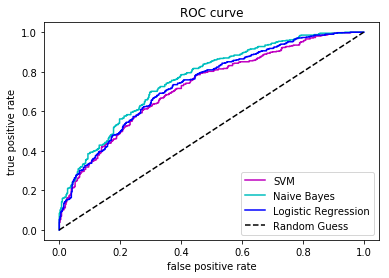

In [17]:
# roc curve
plt.plot(svm_fpr, svm_tpr, "m", label='SVM')
plt.plot(nb_fpr, nb_tpr, "c", label='Naive Bayes')
plt.plot(lg_fpr, lg_tpr, "b", label='Logistic Regression')
plt.plot([0,1],[0,1], "k--", label='Random Guess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
# plt.show()
plt.savefig('AUC.png')

### CNN

In [18]:
# text preprocessing
x_train = []
for i in range(train.shape[0]):
    x_train.append(preprocess(train.iloc[i, 2]))    

x_test = []
for i in range(test.shape[0]):
    x_test.append(preprocess(test.iloc[i, 2]))        

In [19]:
all_training_words = [word for tokens in x_train for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in x_train]

TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

211234 words total, with a vocabulary size of 10819
Max sentence length is 576


In [20]:
all_test_words = [word for tokens in x_test for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in x_test]

TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

94594 words total, with a vocabulary size of 7391
Max sentence length is 679


In [21]:
from gensim import models

word2vec = models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin.gz', binary=True)

In [22]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_lyrics, generate_missing=False):
#     embeddings = clean_lyrics.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    embeddings = [get_average_word2vec(lyric_token, vectors, generate_missing) for lyric_token in clean_lyrics]
    return list(embeddings)

In [23]:
training_embeddings = get_word2vec_embeddings(word2vec, x_train, generate_missing=True)

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 500

tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(train["lyrics"].tolist())
training_sequences = tokenizer.texts_to_sequences(train["lyrics"].tolist())
train_word_index = tokenizer.word_index
print("Found %s unique tokens." % len(train_word_index))
train_cnn_data = pad_sequences(training_sequences, 
                               maxlen=MAX_SEQUENCE_LENGTH)

Using TensorFlow backend.


Found 13124 unique tokens.


In [25]:
EMBEDDING_DIM = 300

train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))

for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(13125, 300)


In [26]:
test_sequences = tokenizer.texts_to_sequences(test["lyrics"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [27]:
train['happy']= y_train

train_sad = []
for i in train["mood"].index:
    if train["mood"][i] == "happy":
        train_sad.append(1)
    else:
        train_sad.append(0)

train['sad']= train_sad
y_train = train[mood].values

/Users/minchunshih/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/minchunshih/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [28]:
test['happy']= y_test

test_sad = []
for i in test["mood"].index:
    if test["mood"][i] == "happy":
        test_sad.append(1)
    else:
        test_sad.append(0)

test['sad']= test_sad
y_test = test[mood].values

/Users/minchunshih/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/minchunshih/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [29]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, GlobalMaxPooling1D, Conv1D

def build_model(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):

    model = Sequential()
    model.add(Embedding(num_words, 
                        embedding_dim,
                        weights=[embeddings],
                        input_length=max_sequence_length,
                        trainable=False))

    num_filters = 128
    filter_size = 2
    model.add(Conv1D(filters=num_filters, # the number of output filters, filter的數量
                     kernel_size= filter_size, # the length of the 1D convolution window, filter的寬度(一次抓取的單字數)
                     activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))    
    num_classes = len(mood)
    model.add(Dense(num_classes, activation='softmax')) # 2 neurons
    
    return model

In [32]:
# model = build_model(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
# history = model.fit(train_cnn_data, y_train, validation_data=(test_cnn_data, y_test), epochs=5, shuffle=True)
# get_confusion_matrix(model, test_cnn_data, y_test[:,0])


# predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)
# model.evaluate(test_cnn_data, y_test, verbose=False)

In [30]:
# https://medium.com/@yanweiliu/python機器學習筆記-四-使用scikit-learn進行邏輯迴歸分析-a5769715015d
# precision = TP / (TP + FP)
# recall = TP / (TP + FN) 能夠預測多少正樣本的比例
# accuracy = (TP + TN) / (TN + FP + FN + TP)
# f1 score = 2TP / (2TP + FP + FN) Precision 和 Recall 的平衡
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from collections import Counter

def get_f1(matrix_values):
    tn, fp, fn, tp = matrix_values[0], matrix_values[1], matrix_values[2], matrix_values[3]
    f1 = round(2*tp/(2*tp+fp+fn), 2)

    return (f1)


def get_true_y(y):
    # y: first column is lay, second column is specialized
    # transfer the format of true y
    y_true = []
    for i in range(len(y)):
        if y[i] == 1.:
            y_true.append(0) # 0 is happy
        else:
            y_true.append(1) # 1 is sad
    y_true = np.array(y_true)
    return (y_true)


def get_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X)
    y_true = get_true_y(y)

    auc_score = roc_auc_score(y, model.predict(X)[:,0])

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = round((tp+tn)/(tn+fp+fn+tp), 2)
    conf_matrix = pd.DataFrame([[tp, fp], [fn, tn]], columns=["Happy", "Sad"], index=["pred Happy", "pred Sad"]) 
  
    f1_sad = get_f1((tp, fn, fp, tn))
    f1_happy = get_f1((tn, fp, fn, tp))

    count = Counter(y_true)
    count_sad = count[0]
    count_happy = count[1]

    f1_avg = round((f1_sad*count_sad + f1_happy*count_happy)/(count_sad+count_happy), 2)

    return (conf_matrix, [f1_avg, f1_sad, f1_happy], accuracy, auc_score)

In [31]:
all_f1_avg = {}
all_f1_sad = {}
all_f1_happy = {}
all_accuracy = {}
all_auc_score = {}

for i in range(5):
    print (i)
    
    model = build_model(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(mood)))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    history = model.fit(train_cnn_data, y_train, validation_data=(test_cnn_data, y_test), epochs=5, shuffle=True)
    conf_matrix, f1, accuracy, auc_score  = get_confusion_matrix(model, test_cnn_data, y_test[:,0])
    all_f1_avg[i] = f1[0]
    all_f1_sad[i] = f1[1]
    all_f1_happy[i] = f1[2]
    all_accuracy[i] = accuracy
    all_auc_score[i] = auc_score

0
Train on 1910 samples, validate on 819 samples
Epoch 1/5
1910/1910 [==============================] - 5s 3ms/step - loss: 0.7413 - accuracy: 0.5366 - val_loss: 0.6884 - val_accuracy: 0.5397
Epoch 2/5
1910/1910 [==============================] - 5s 3ms/step - loss: 0.6432 - accuracy: 0.6215 - val_loss: 0.6329 - val_accuracy: 0.6361
Epoch 3/5
1910/1910 [==============================] - 5s 3ms/step - loss: 0.5680 - accuracy: 0.7236 - val_loss: 0.6261 - val_accuracy: 0.6215
Epoch 4/5
1910/1910 [==============================] - 5s 3ms/step - loss: 0.5210 - accuracy: 0.7649 - val_loss: 0.5979 - val_accuracy: 0.6654
Epoch 5/5
1910/1910 [==============================] - 5s 3ms/step - loss: 0.4688 - accuracy: 0.7911 - val_loss: 0.6095 - val_accuracy: 0.6716
1
Train on 1910 samples, validate on 819 samples
Epoch 1/5
1910/1910 [==============================] - 6s 3ms/step - loss: 0.7335 - accuracy: 0.5497 - val_loss: 0.6575 - val_accuracy: 0.6093
Epoch 2/5
1910/1910 [=======================

In [32]:
from statistics import mean 

print ("Accuracy: " + str(mean(all_accuracy.values())), ", Auc score: " + str(mean(all_auc_score.values())))
print ("F1 average: " + str(mean(all_f1_avg.values())), ", F1 sad: " + str(mean(all_f1_sad.values())), ", F1 happy: " + str(mean(all_f1_happy.values())))

Accuracy: 0.686 , Auc score: 0.761211380174162
F1 average: 0.682 , F1 sad: 0.7 , F1 happy: 0.662


In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

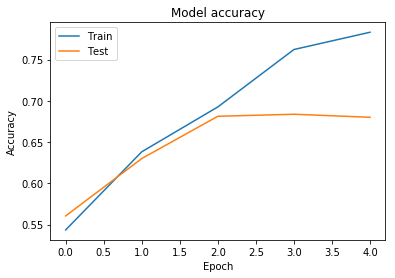

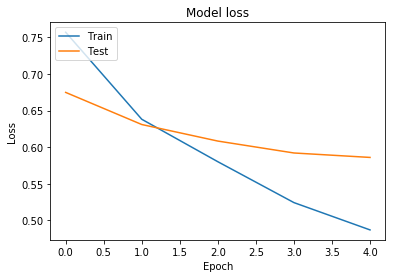

In [34]:
plot_history(history)
# print (conf_matrix)